#
http://enu.kz/repository/2010/AIAA-2010-3412.pdf

In [92]:
import os
import glob
import LatLon 
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 5)

# plot
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
sns.set_style("whitegrid")
from pysurvey.plot import setup, legend, icolorbar, density, minmax

# date
from dateutil import parser
from matplotlib.dates import date2num

# database
import dataset
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

import sompy as SOM

In [35]:
before = pd.DataFrame.from_csv('/Users/ajmendez/tmp/flight/flight_before.csv')
after = pd.DataFrame.from_csv('/Users/ajmendez/tmp/flight/flight_after.csv')
during = pd.DataFrame.from_csv('/Users/ajmendez/tmp/flight/flight_during.csv')


In [241]:
from sklearn import manifold, datasets, cluster

n_neighbors = 5
n_components = 2
n_points=10000

In [242]:
input_tags = ['lat', 'lon', 'alt', 'hour', 'flightnum']

def make_data(cat):
    np.random.seed(0)
    ii = np.random.choice(before.index, n_points)
    X = np.zeros( (n_points, len(input_tags)) )
    for i,tag in enumerate(input_tags):
        tmp = before[tag][ii]
        X[:, i] = (tmp-tmp.mean()) / tmp.std()
    color = np.array(before['flightnum'][ii])
    return X, color
X, YModel = make_data(during)
print X.shape

(10000, 5)


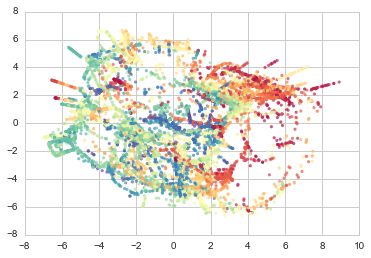

In [248]:
isomap = manifold.Isomap(n_neighbors, n_components)
Y = isomap.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], c=YModel, s=10, cmap=plt.cm.Spectral, alpha=0.7, lw=0)

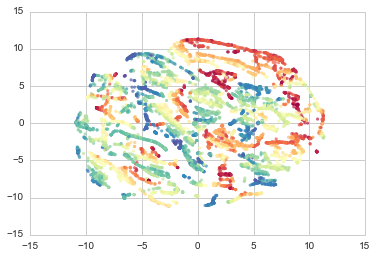

In [249]:
# Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], c=YModel, s=10, cmap=plt.cm.Spectral, alpha=0.7, lw=0)

In [ ]:
se = manifold.SpectralEmbedding(n_components=n_components, affinity='rbf', n_neighbors=n_neighbors, random_state=0)
Y = se.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], c=color, s=10, cmap=plt.cm.Spectral, alpha=0.7, lw=0)

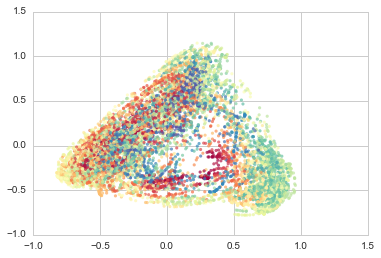

In [252]:
plt.scatter(Y[:, 0], Y[:, 1], c=YModel, s=10, cmap=plt.cm.Spectral, alpha=0.7, lw=0)

In [ ]:
mds = manifold.MDS(n_components, max_iter=100, n_init=1, random_state=0)
Y = mds.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], c=color, s=10, cmap=plt.cm.Spectral, alpha=0.7, lw=0)

In [ ]:
plt.scatter(Y[:, 0], Y[:, 1], c=YModel, s=10, cmap=plt.cm.Spectral, alpha=0.7, lw=0)

# Clustering

In [236]:
colors = np.array([x for x in 'bgrcmybgrcmybgrcmybgrcmy'])
colors = np.hstack([colors] * 40)

def run_clustering(model, **kwargs):
    alg = model(**kwargs)
    alg.fit(X)
    if hasattr(alg, 'labels_'):
        y_pred = alg.labels_.astype(np.int)
    else:
        y_pred = alg.predict(X)
    return y_pred

def plot_clustering(y_pred):
    pylab.figure(figsize=(12,6))
    pylab.subplot(121)
    pylab.title('Model')
    plt.scatter(X[:, 0], X[:, 1], c=YModel, s=10, lw=0, cmap=pylab.cm.jet)
    pylab.subplot(122)
    plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=10, lw=0, cmap=pylab.cm.jet)

(0, 89) 0.895913599182 90 685


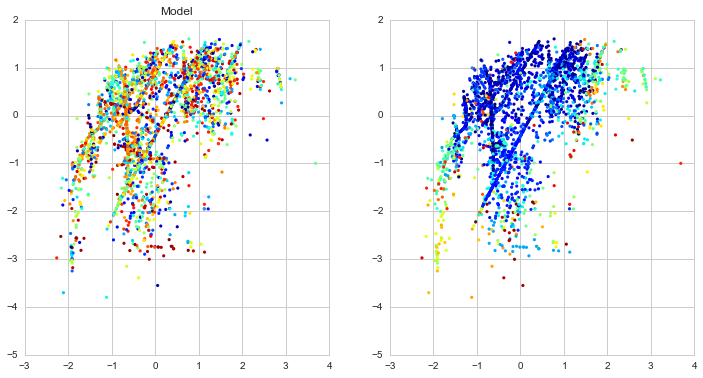

In [234]:
bandwidth = cluster.estimate_bandwidth(X, quantile=0.009)
y_pred = run_clustering(cluster.MeanShift, bandwidth=bandwidth, bin_seeding=True)
plot_clustering(y_pred)
print minmax(y_pred), bandwidth, len(np.unique(y_pred)), len(np.unique(Ymodel))

(-1, 80) 0.895913599182 82 685


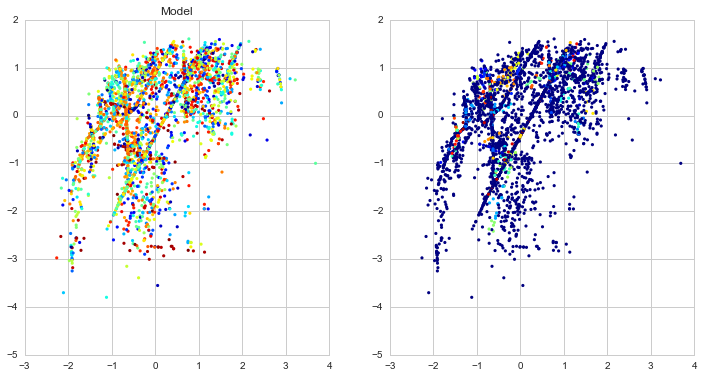

In [237]:
y_pred = run_clustering(cluster.DBSCAN, eps=0.3)
plot_clustering(y_pred)
print minmax(y_pred), bandwidth, len(np.unique(y_pred)), len(np.unique(Ymodel))

In [169]:
from sklearn.neighbors import kneighbors_graph

(0, 684) 0.895913599182 685 685


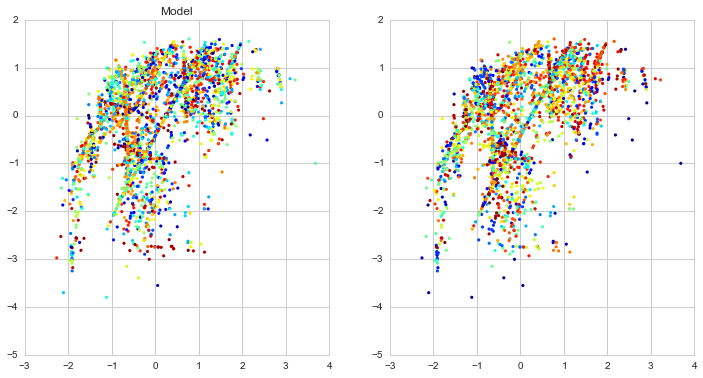

In [238]:
n_clusters = len(np.unique(Ymodel))
connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
connectivity = 0.5 * (connectivity + connectivity.T)
y_pred = run_clustering(cluster.AgglomerativeClustering, 
                        n_clusters=n_clusters, linkage='ward',
                        connectivity=connectivity)
plot_clustering(y_pred)
print minmax(y_pred), bandwidth, len(np.unique(y_pred)), len(np.unique(Ymodel))

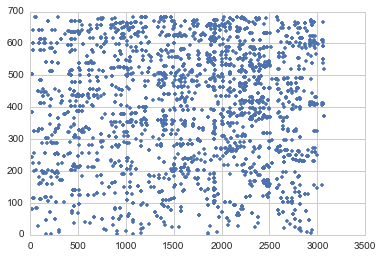

In [239]:
ii = np.argsort(y_pred)
pylab.plot(Ymodel[ii], y_pred[ii], '.')